In [5]:
%matplotlib inline
import matplotlib as mplt 
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib 
from matplotlib.ticker import FuncFormatter 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from utils_libs import *

import pickle

In [3]:
a = [[[1], [2], [3]]]

a = np.asarray(a)
print(np.shape(a))

b = [[[10], [20], [30]]]

b = np.asarray(b)
print(np.shape(b))


(1, 3, 1)
(1, 3, 1)


In [26]:
a = [[1, ['a']], [2, ['b']], [3, ['c']]]


tmpmin = min(a, key = lambda x: x[0])
print(tmpmin)

tmpidx = a.index(tmpmin)

print(tmpidx)

[1, ['a']]
0


In [25]:
del a[:3]
print(a)

[4]


In [5]:
np.sum([[0, 1, 3], [0, 5, 13]], axis=0)


array([ 0,  6, 16])

In [7]:
from utils_training import *

para_hpara_range = [[0.001, 0.001], [16, 80], [1e-7, 0.1]]
para_hpara_n_trial = 15

hpara_generator = hpara_random_search(para_hpara_range, 
                                              para_hpara_n_trial)

tmp_hpara = hpara_generator.hpara_trial()
cnt = 0

while tmp_hpara != None:
    
    print(tmp_hpara)
    
    tmp_hpara = hpara_generator.hpara_trial()
    
    cnt += 1
    
print(cnt)


(0.001, 21.637187473496112, 0.007959347501732862)
(0.001, 78.40982194217423, 0.07261109046914715)
(0.001, 52.59216391399862, 0.09097181811818338)
(0.001, 33.23521074358985, 0.08432522086525719)
(0.001, 20.96687433539943, 0.052003505556886036)
(0.001, 35.62823140405692, 0.06381843792206282)
(0.001, 21.892380553073572, 0.02096373119703489)
(0.001, 30.955982065237926, 0.08078347382987816)
(0.001, 33.320986978493046, 0.055215850986332575)
(0.001, 24.672662393668112, 0.010174357187866953)
(0.001, 26.830600155940324, 0.07787018333062594)
(0.001, 20.716800964911947, 0.06336641821299299)
(0.001, 26.13412406644985, 0.008806461912839058)
(0.001, 32.857377100554146, 0.02020961054360036)
(0.001, 38.84114049699179, 0.04848475665772599)
15


In [6]:
from utils_training import *


para_lr_range = [0.001, ]
para_batch_range = [64, 32, 16, 80]
para_l2_range = [1e-7, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

hpara_generator = hpara_grid_search([para_lr_range, para_batch_range, para_l2_range])

tmp_hpara = hpara_generator.hpara_trial()
cnt = 0

while tmp_hpara != None:
    
    print(tmp_hpara)
    
    tmp_hpara = hpara_generator.hpara_trial()
    
    cnt += 1
    
print(cnt)
    

[0.001, 64, 1e-07]
[0.001, 64, 1e-06]
[0.001, 64, 1e-05]
[0.001, 64, 0.0001]
[0.001, 64, 0.001]
[0.001, 64, 0.01]
[0.001, 64, 0.1]
[0.001, 32, 1e-07]
[0.001, 32, 1e-06]
[0.001, 32, 1e-05]
[0.001, 32, 0.0001]
[0.001, 32, 0.001]
[0.001, 32, 0.01]
[0.001, 32, 0.1]
[0.001, 16, 1e-07]
[0.001, 16, 1e-06]
[0.001, 16, 1e-05]
[0.001, 16, 0.0001]
[0.001, 16, 0.001]
[0.001, 16, 0.01]
[0.001, 16, 0.1]
[0.001, 80, 1e-07]
[0.001, 80, 1e-06]
[0.001, 80, 1e-05]
[0.001, 80, 0.0001]
[0.001, 80, 0.001]
[0.001, 80, 0.01]
[0.001, 80, 0.1]
28


In [14]:
np.random.random()

0.4347790920729012

In [13]:
def mape(y, 
         yhat):
    
    tmp_list = []
    
    for idx, val in enumerate(y):
        
        if abs(val) > 1e-5:
            tmp_list.append(abs(1.0*(yhat[idx]-val)/val))
    
    return np.mean(tmp_list)

def mae(y, 
        yhat):
    
    return np.mean(np.abs(np.asarray(y) - np.asarray(yhat)))
    
def rmse(y, 
         yhat):
    
    return np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2))

def data_reshape(data, 
                 bool_target_seperate):
    
    # data: [yi, ti, [xi_src1, xi_src2, ...]]
    src_num = len(data[0][2])
    tmpx = []
    
    if bool_target_seperate == True:
        
        tmpx.append(np.asarray([tmp[2][0][:, 1:] for tmp in data]))
        print(np.shape(tmpx[-1]))
    
        tmpx.append(np.asarray([tmp[2][0][:, 0:1] for tmp in data]))
        print(np.shape(tmpx[-1]))
        
        for src_idx in range(1, src_num):
            tmpx.append(np.asarray([tmp[2][src_idx] for tmp in data]))
            print(np.shape(tmpx[-1]))
    
    else:
        
        for src_idx in range(src_num):
            tmpx.append(np.asarray([tmp[2][src_idx] for tmp in data]))
            print("src " + str(src_idx) + " : ", np.shape(tmpx[-1]))
    
    tmpy = np.asarray([tmp[0] for tmp in data])
    
    # output shape: x [S N T D],  y [N 1]
    return tmpx, np.expand_dims(tmpy, -1)

def rmse_mae_quantiles(target, 
                       pred, 
                       q):
    
    # q = number of quantiles
    
    x_sort = sorted(list(target))

    quant_val = [x_sort[i*int(len(x_sort)/q)] for i in range(1, q)]
    quant_val.append(max(x_sort)+1)

    sq_error_quant = [0 for _ in quant_val]
    abs_error_quant = [0 for _ in quant_val]
    abs_per_error_quant = [0 for _ in quant_val]
    
    num_quant = [0 for x in quant_val]
    
    num_mape_quant = [0 for x in quant_val]
    
    for i in range(1, len(x_sort)):
        
        tmp_vol = target[i]
        tmp_resi = target[i] - pred[i]
        
        q_idx = list(map(lambda j: j>tmp_vol, quant_val)).index(True)   
        
        sq_error_quant[q_idx] += tmp_resi**2
        abs_error_quant[q_idx] += abs(tmp_resi)
        num_quant[q_idx]+=1
        
        if abs(tmp_vol)>1e-5:
            
            abs_per_error_quant[q_idx] += abs(1.0*tmp_resi/tmp_vol)
            num_mape_quant[q_idx] += 1
        
        
    rmse_quantiles = [sqrt(sq_error_quant[j]/num_quant[j]) for j in range(0, len(quant_val))] 
    mae_quantiles = [abs_error_quant[j]/num_quant[j] for j in range(0, len(quant_val))] 
    
    mape_quantiles = [abs_per_error_quant[j]/num_mape_quant[j] for j in range(0, len(quant_val))] 
    
    return rmse_quantiles, mae_quantiles, mape_quantiles, quant_val

def result_plot(y, 
                path_res, 
                plot_l, 
                plot_r, 
                plot_title):
    
    py = pickle.load(open(path_res + ".p", "rb"), \
                     encoding='latin1')

    py_mean = py[0]
    py_var = py[1]
    
    print(np.shape(ts_y))
    #print(np.shape(py))

    num = len(ts_y)
    print("MAE", mae(ts_y, py_mean))
    print("RMSE", rmse(ts_y, py_mean))
    
#   -- mean  
    fig, ax = plt.subplots(figsize=(15,8));
    
    ax.plot(range(plot_l, plot_r), ts_y[plot_l: plot_r], label = 'truth',  marker='o');
    ax.plot(range(plot_l, plot_r), py_mean[plot_l: plot_r], label = 'prediction',  marker='o');
    
    ax.set_title(plot_title)
    ax.legend()
    
#   -- variance
    fig, ax = plt.subplots(figsize=(15,5));
    
    ax.plot(range(plot_l, plot_r), py_var[plot_l: plot_r], label = 'volatility',  marker='o');
    
    ax.set_title(plot_title)
    ax.legend()
    
#   -- histogram
    fig, ax = plt.subplots();

    ax.hist(py_mean, 2000);
    ax.set_xlim([-10, 50])
    ax.set_title(plot_title)
    
#   -- quantial conditional
    rmse_quantiles, mae_quantiles, mape_quantiles, quant_val = rmse_mae_quantiles(np.squeeze(ts_y), 
                                                                                  np.squeeze(py_mean), 
                                                                                  10)
    
    print("Quantiles", quant_val, '\n')
    
    print("  RMSE", rmse_quantiles)
    print("  MAE", mae_quantiles)
    print("  MAPE", mape_quantiles)
    


src 0 :  (34346, 10, 7)
src 1 :  (34346, 10, 7)
src 2 :  (34346, 10, 10)


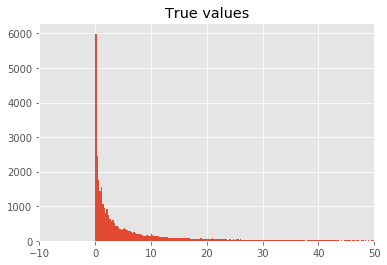

In [4]:

gaussian_lk_inv = ["py_gaussian_lk_inv_none_none",  
      "py_gaussian_lk_inv_independent_none",
      "py_gaussian_lk_inv_markov_constant_diff_sq",
      "py_gaussian_lk_inv_markov_scalar_diff_sq",
      "py_gaussian_lk_inv_markov_vector_diff_sq",
      "py_gaussian_lk_inv_markov_pos_neg_diff_sq"]


gaussian_lk = ["py_gaussian_lk_none_none",
      "py_gaussian_lk_independent_none",
      "py_gaussian_lk_markov_constant_diff_sq",
      "py_gaussian_lk_markov_scalar_diff_sq",
      "py_gaussian_lk_markov_vector_diff_sq",
      "py_gaussian_lk_markov_pos_neg_diff_sq"
     ]


path_data = "../dataset/bitcoin/double_trx_ob_tar1_len10/"

ts_dta = pickle.load(open(path_data + 'test.p', "rb"), encoding = 'latin1')
    
ts_x, ts_y = data_reshape(ts_dta,
                          bool_target_seperate = False)

fig, ax = plt.subplots();

ax.hist(ts_y, 2000);
ax.set_xlim([-10, 50]);
ax.set_title("True values");


 --------  py_gaussian_lk_inv_none_none
(34346, 1)
MAE 8.686509783529049
RMSE 22.758746530306702
Quantiles [0.09125508, 0.33173101, 0.7838064100000001, 1.40505704, 2.38401153, 3.95315725, 6.58127803, 11.668147089999994, 25.503929119999995, 510.05139949] 

  RMSE [8.52314004836259, 12.1105526081563, 6.173103880841695, 9.622343362592355, 3.414511393622627, 3.107724431085796, 6.382270714335346, 8.884780830011639, 13.729402243876656, 67.031460389255]
  MAE [3.2454014563673197, 3.277956873679283, 3.027906866766979, 2.8354661866424413, 2.0929456689869568, 1.5019078298441695, 2.099396174925982, 4.692058018038357, 12.023682001537665, 51.99490799268706]
  MAPE [284.0038126229513, 18.610519386458947, 6.025158745406477, 2.7346739951348407, 1.1612546180445087, 0.49908938227967325, 0.40793596128085435, 0.5219211523513062, 0.6807980250788258, 0.826740025372226]

 --------  py_gaussian_lk_inv_independent_none
(34346, 1)
MAE 8.515889831375736
RMSE 22.314909495429074
Quantiles [0.09125508, 0.33173101,

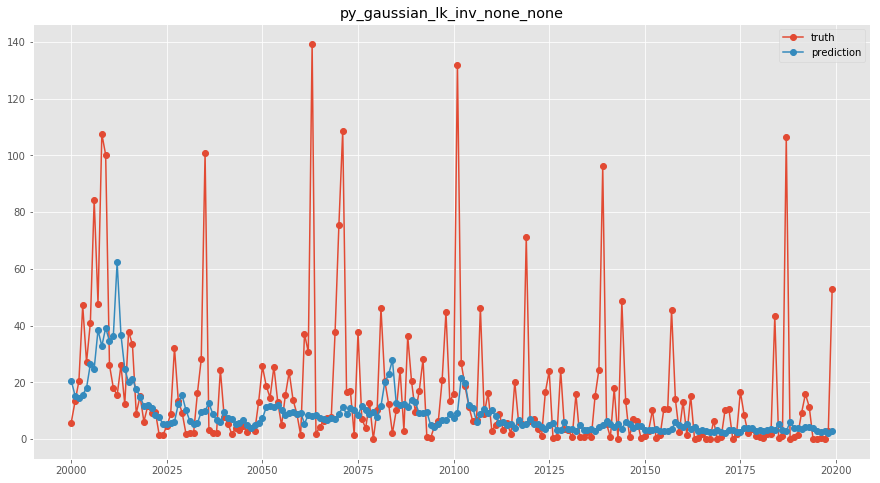

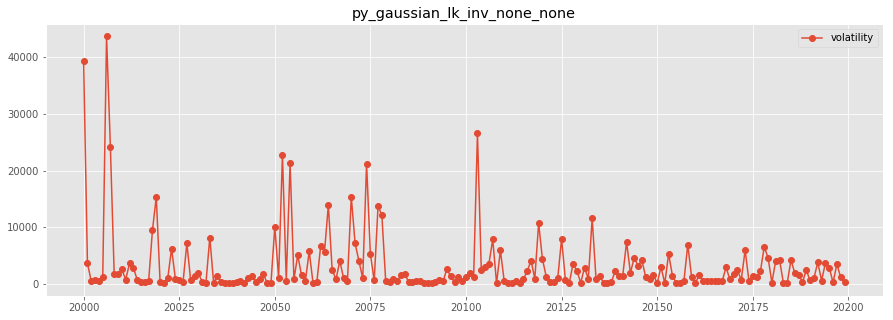

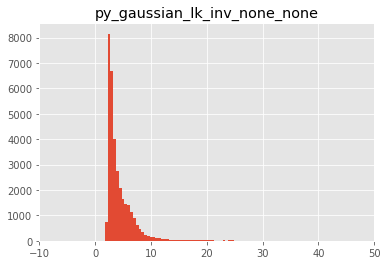

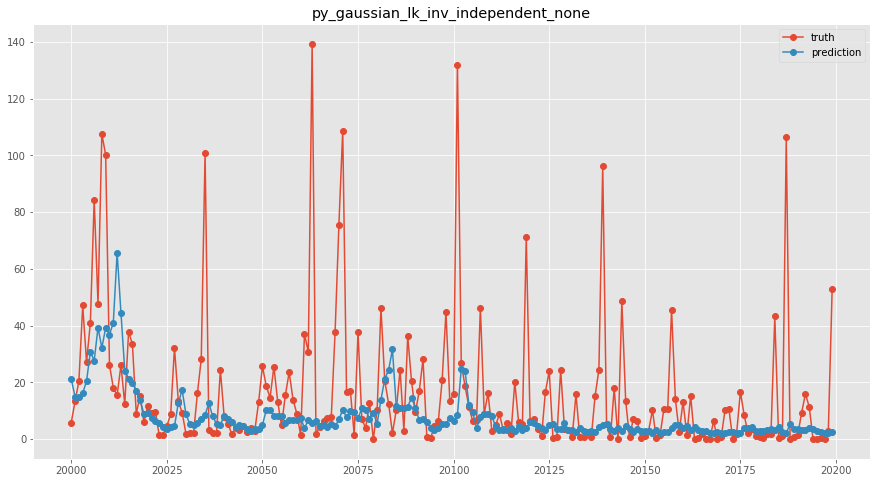

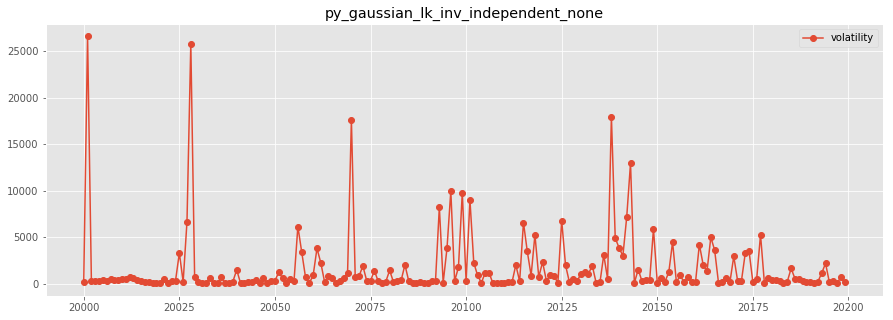

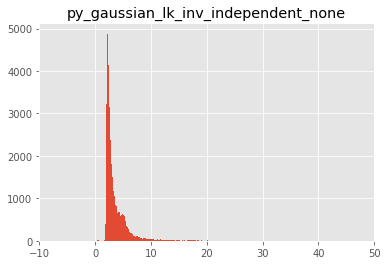

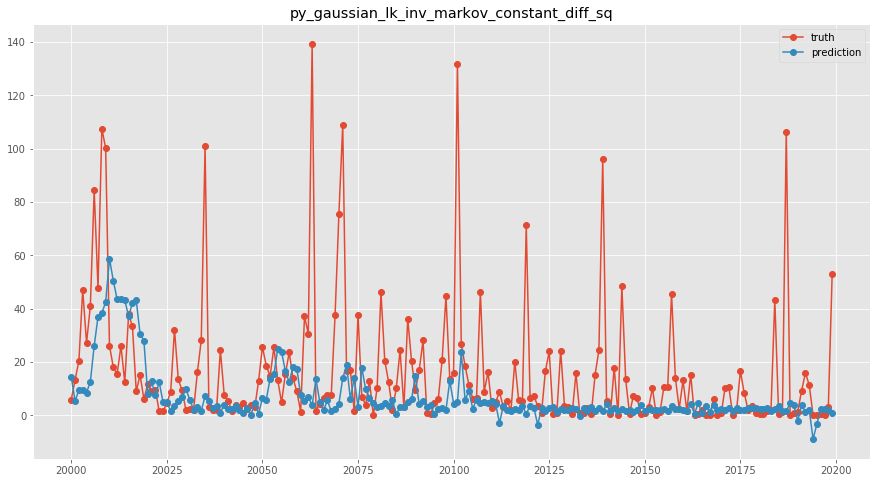

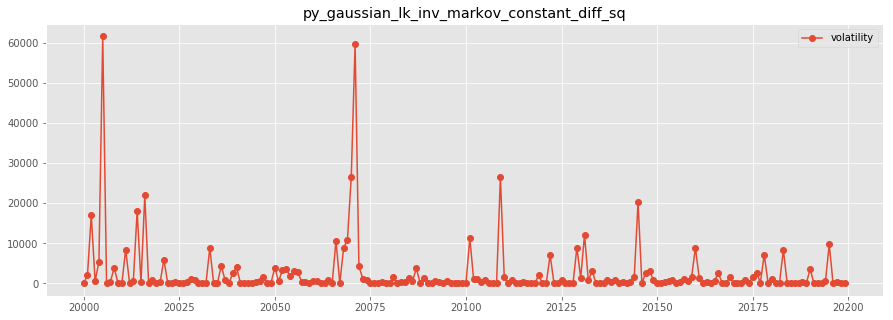

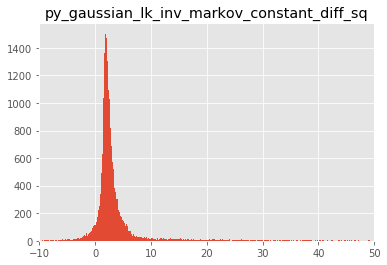

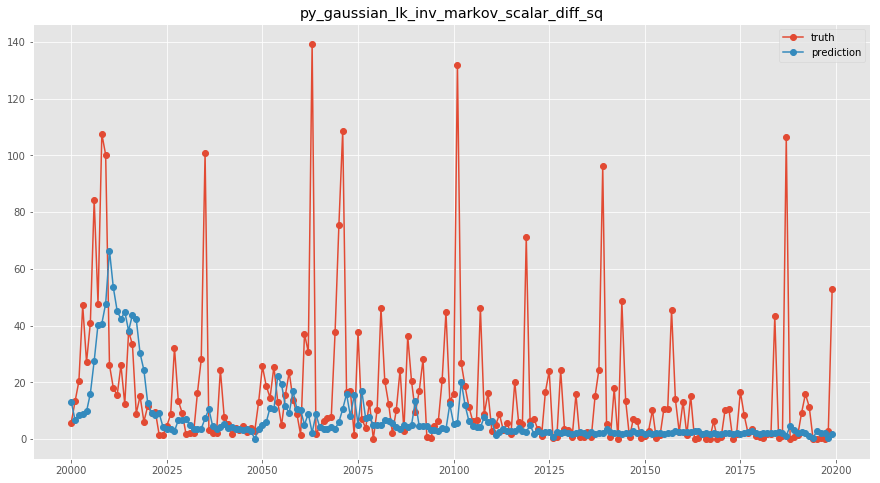

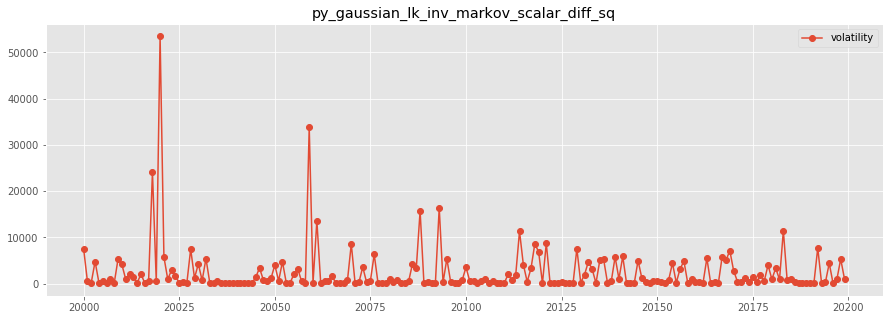

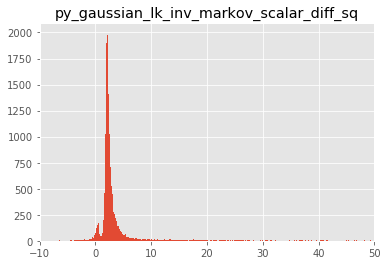

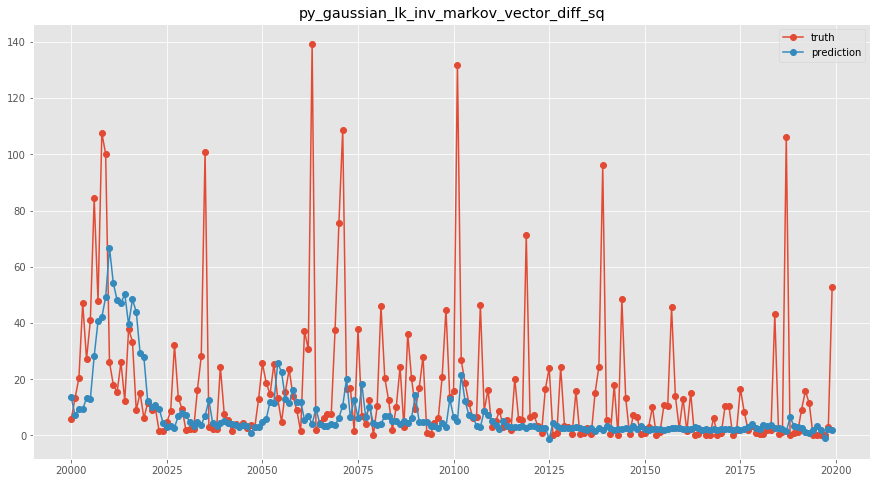

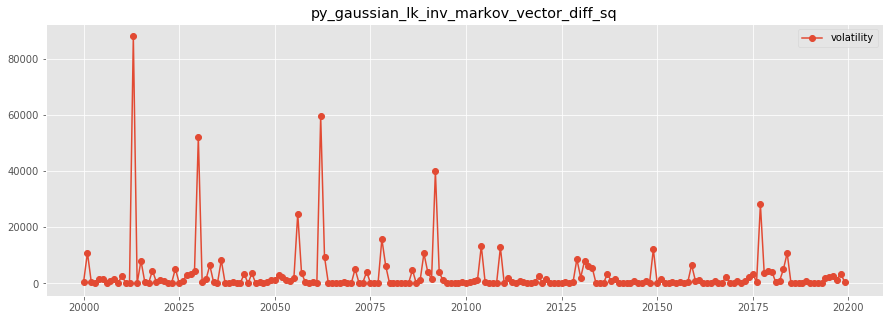

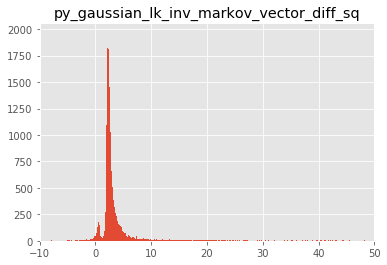

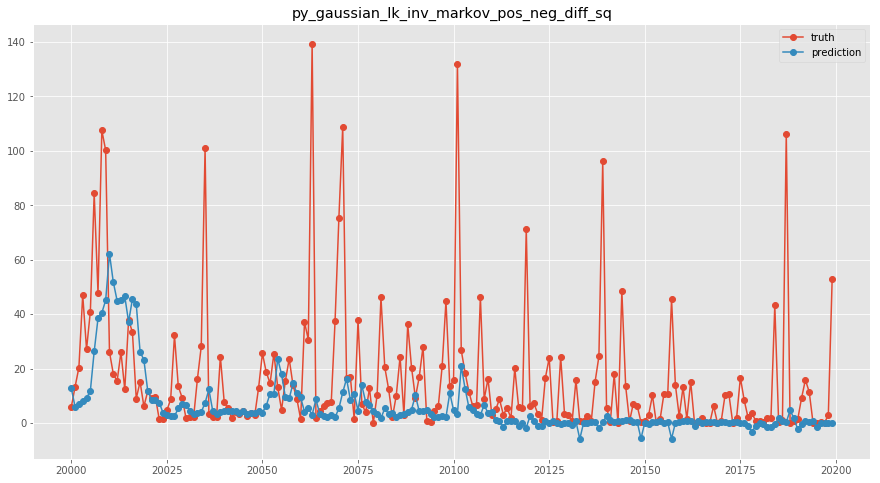

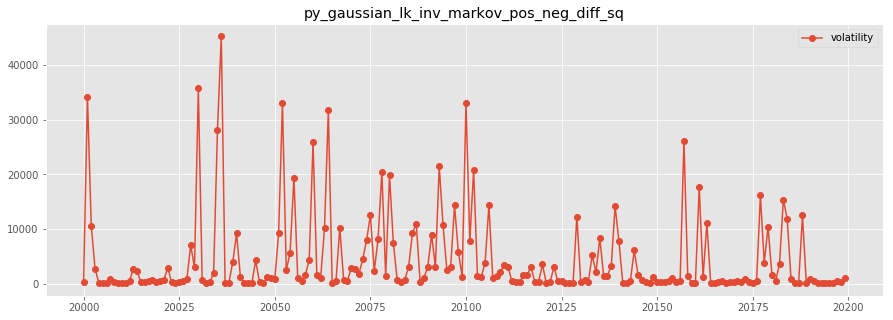

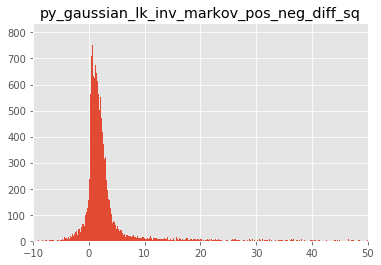

In [20]:
plot_l = 20000
plot_r = 20200

path_res = "../results/mixture_gc_py_src_tar_1min/" 

for tmp_path in gaussian_lk_inv:
    
    print("\n -------- ", tmp_path)
    
    result_plot(ts_y, 
                path_res + tmp_path, 
                plot_l, 
                plot_r, 
                tmp_path)


 --------  py_gaussian_lk_inv_none_none
(34346, 1)
MAE 8.686509783529049
RMSE 22.758746530306702
Quantiles [0.09125508, 0.33173101, 0.7838064100000001, 1.40505704, 2.38401153, 3.95315725, 6.58127803, 11.668147089999994, 25.503929119999995, 510.05139949] 

  RMSE [8.52314004836259, 12.1105526081563, 6.173103880841695, 9.622343362592355, 3.414511393622627, 3.107724431085796, 6.382270714335346, 8.884780830011639, 13.729402243876656, 67.031460389255]
  MAE [3.2454014563673197, 3.277956873679283, 3.027906866766979, 2.8354661866424413, 2.0929456689869568, 1.5019078298441695, 2.099396174925982, 4.692058018038357, 12.023682001537665, 51.99490799268706]
  MAPE [284.0038126229513, 18.610519386458947, 6.025158745406477, 2.7346739951348407, 1.1612546180445087, 0.49908938227967325, 0.40793596128085435, 0.5219211523513062, 0.6807980250788258, 0.826740025372226]

 --------  py_gaussian_lk_inv_independent_none
(34346, 1)
MAE 8.515889831375736
RMSE 22.314909495429074
Quantiles [0.09125508, 0.33173101,

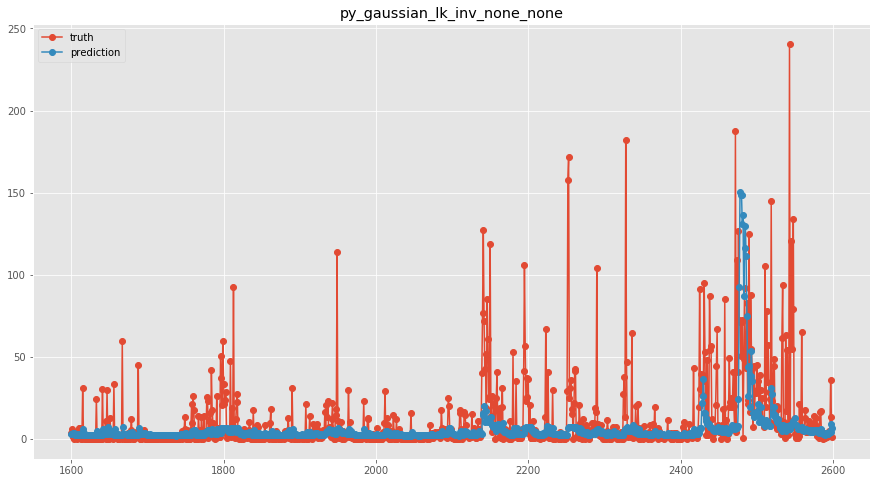

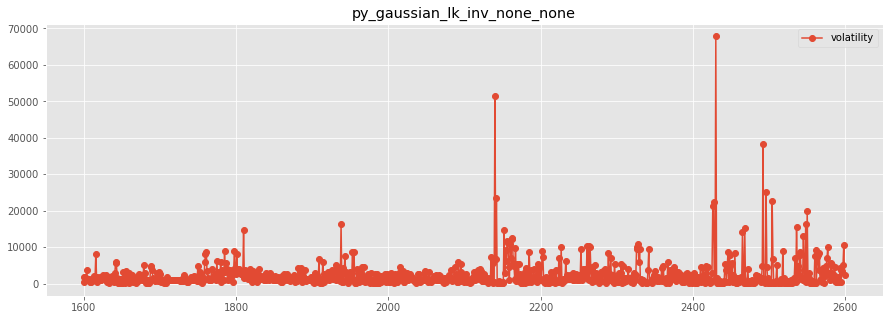

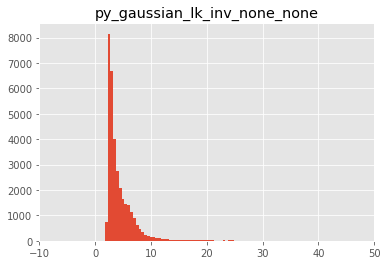

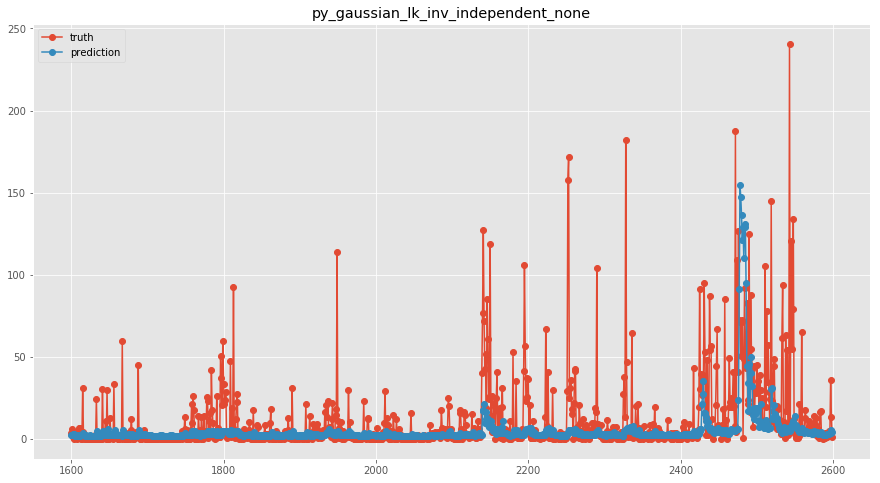

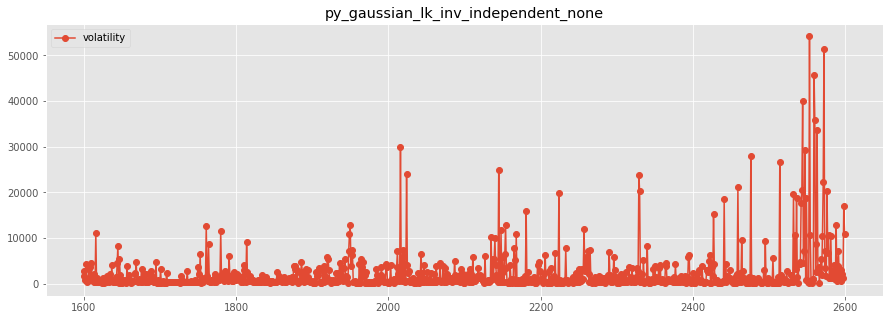

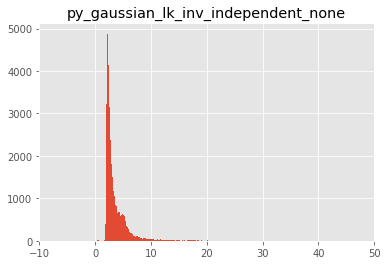

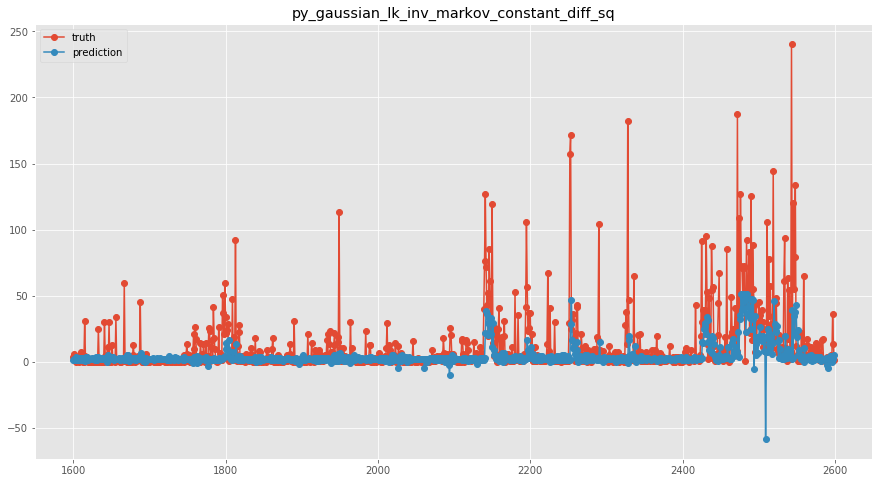

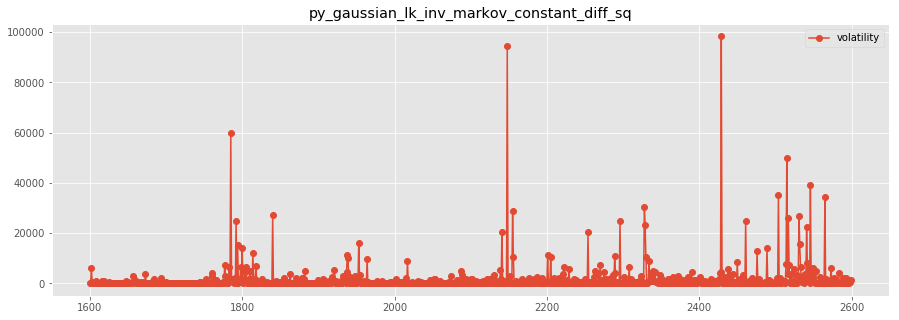

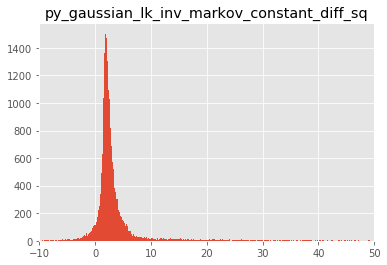

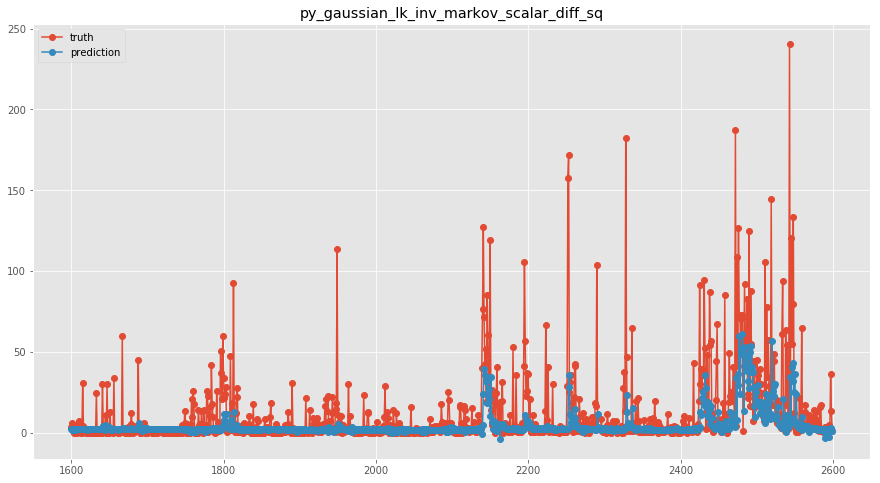

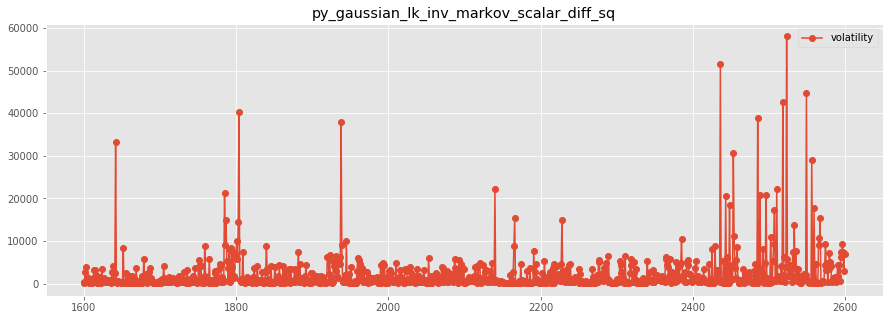

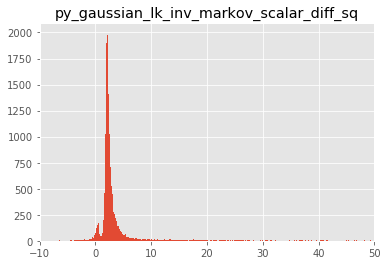

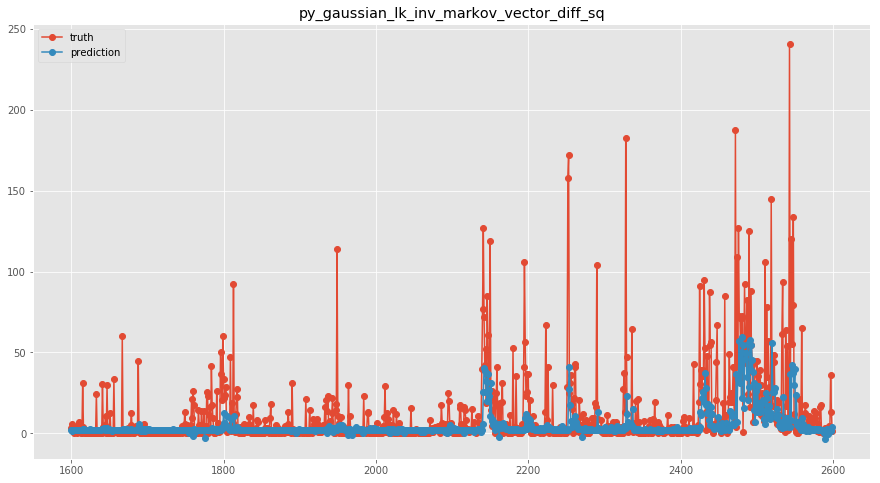

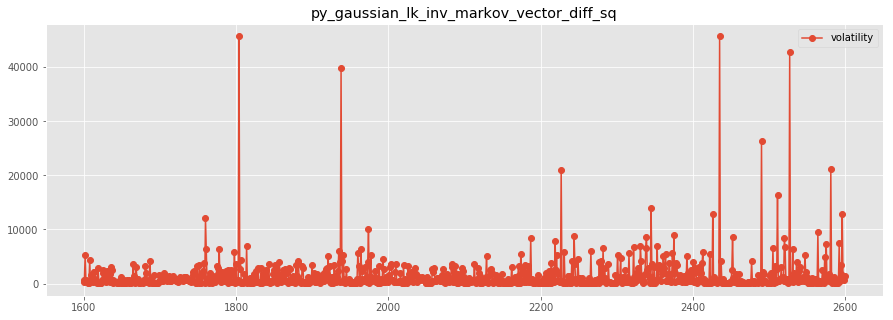

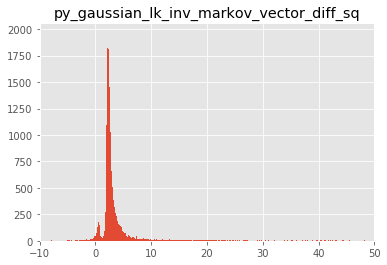

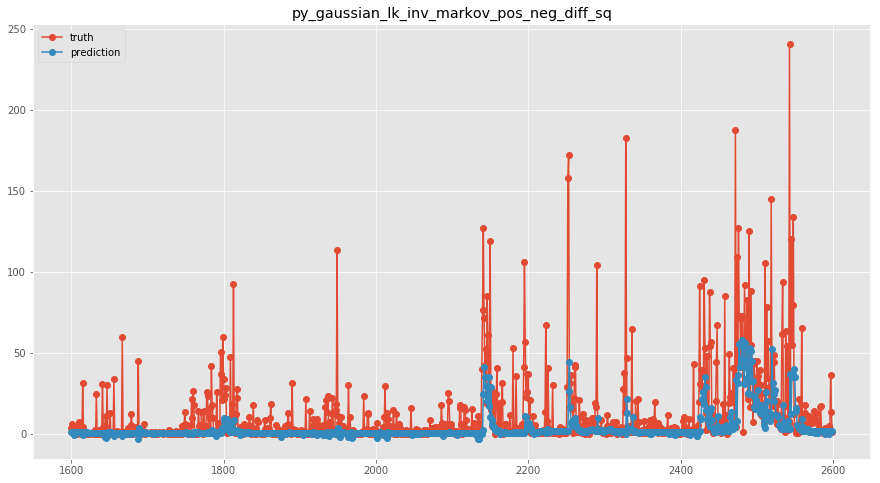

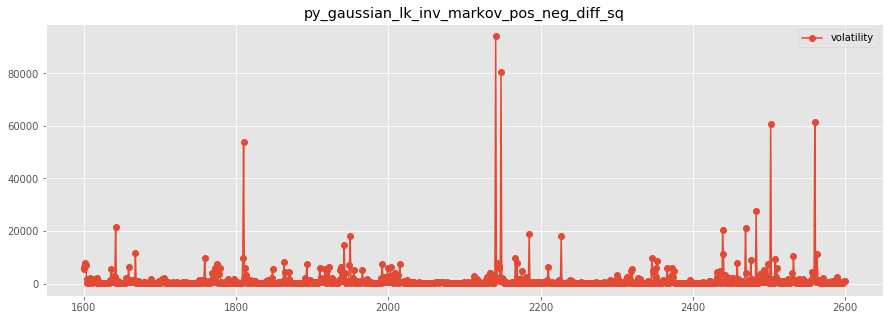

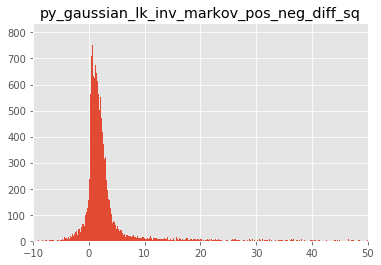

In [17]:
plot_l = 1600
plot_r = 2600

path_res = "../results/mixture_gc_py_tar_1min/" 

for tmp_path in gaussian_lk_inv:
    
    print("\n -------- ", tmp_path)
    
    result_plot(ts_y, 
                path_res + tmp_path, 
                plot_l, 
                plot_r, 
                tmp_path)


 --------  py_gaussian_lk_none_none
(34346, 1)
(2, 34346, 1)
MAE 9.14789687246628
RMSE 23.519686590581625
Quantiles [0.52821867, 2.38473488, 8.76078398, 510.05139949]
  RMSE [4.385521434204369, 2.844849599134336, 4.55438840049908, 46.524244513123485]
  MAE [2.5836135436006638, 1.7010120432044635, 2.294050407561212, 30.010736676311566]

 --------  py_gaussian_lk_independent_none
(34346, 1)
(2, 34346, 1)
MAE 8.484322496447227
RMSE 22.384411288616455
Quantiles [0.52821867, 2.38473488, 8.76078398, 510.05139949]
  RMSE [4.444580738196734, 7.2703906181263465, 10.359542857555082, 42.71065294362603]
  MAE [2.5391808664260975, 1.8676070800018374, 2.67127390629613, 26.856594872682546]

 --------  py_gaussian_lk_markov_constant_diff_sq
(34346, 1)
(2, 34346, 1)
MAE 8.854847704607298
RMSE 21.778826077036058
Quantiles [0.52821867, 2.38473488, 8.76078398, 510.05139949]
  RMSE [2.809519619260736, 3.576182269990516, 6.984950147181116, 42.75134901457726]
  MAE [2.2856300789486146, 1.7730070033687557, 3

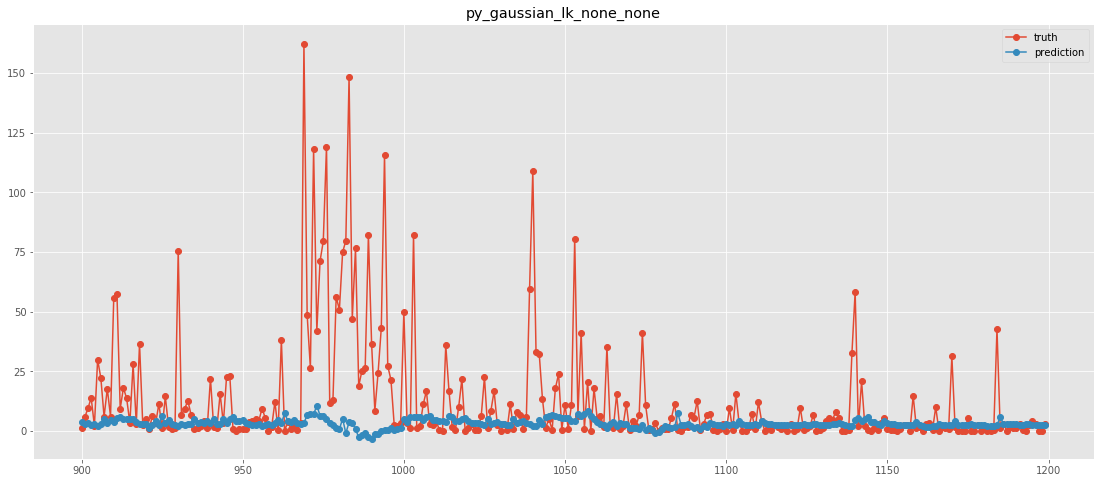

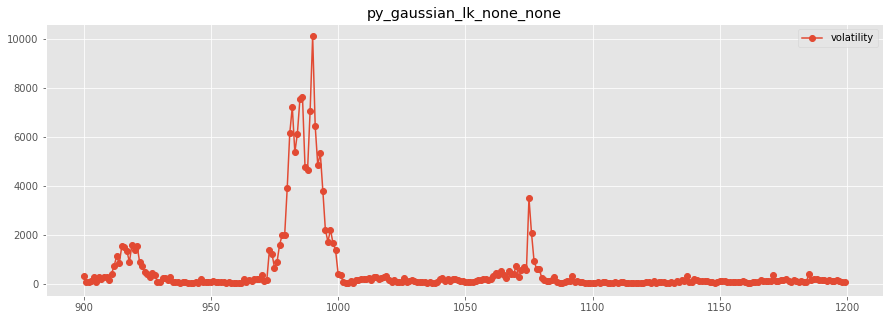

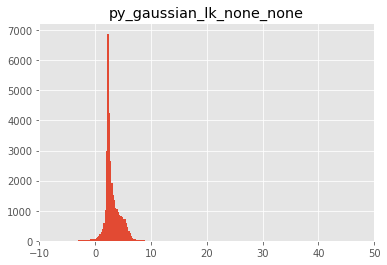

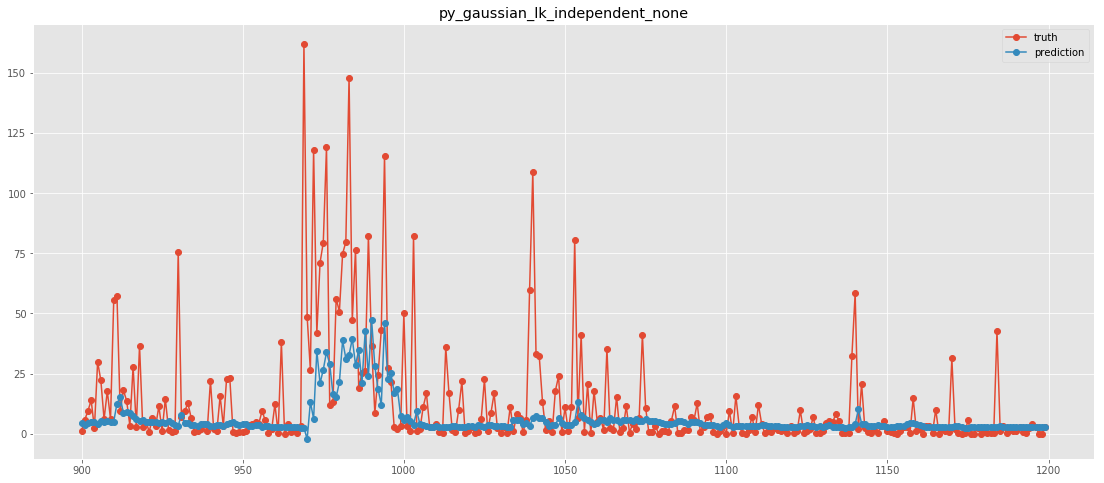

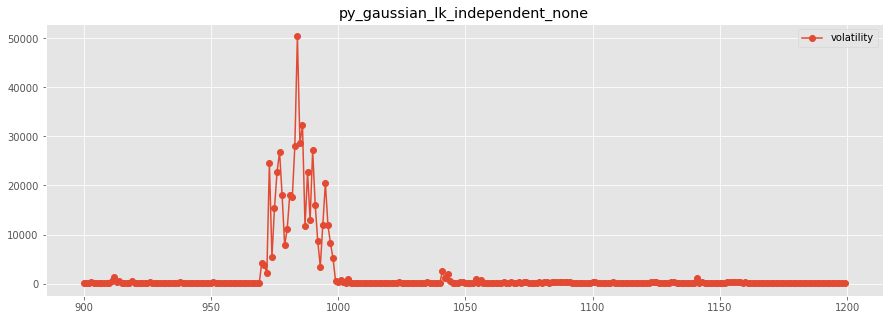

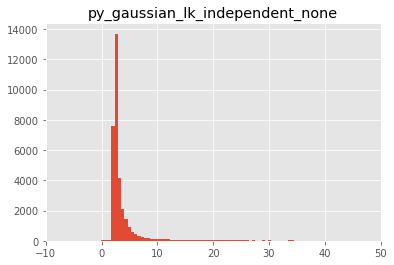

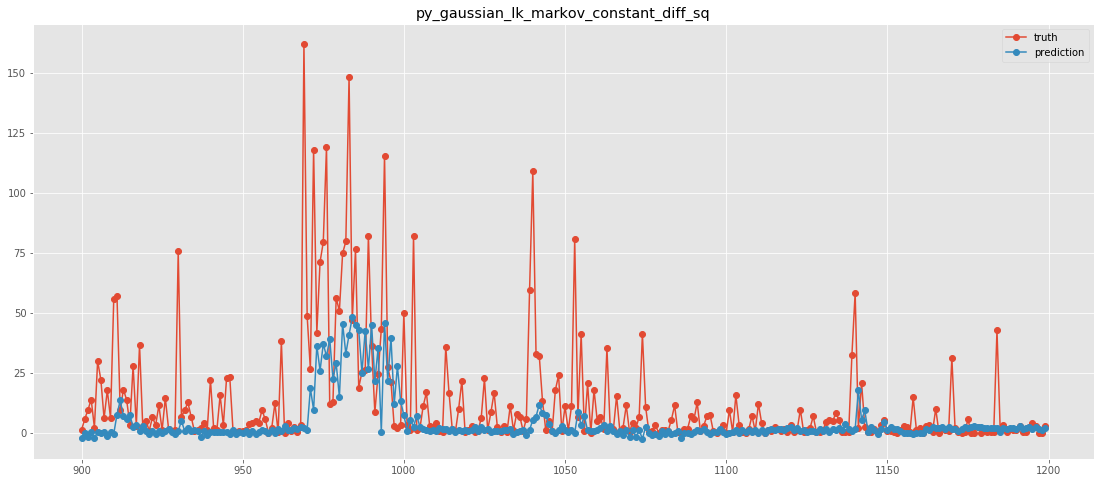

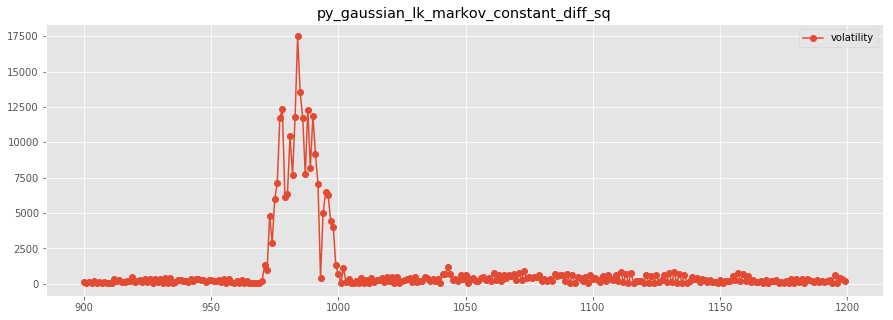

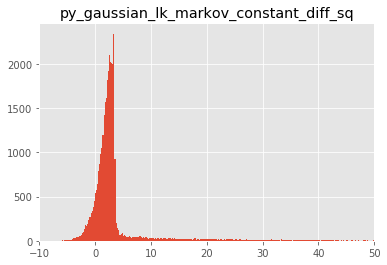

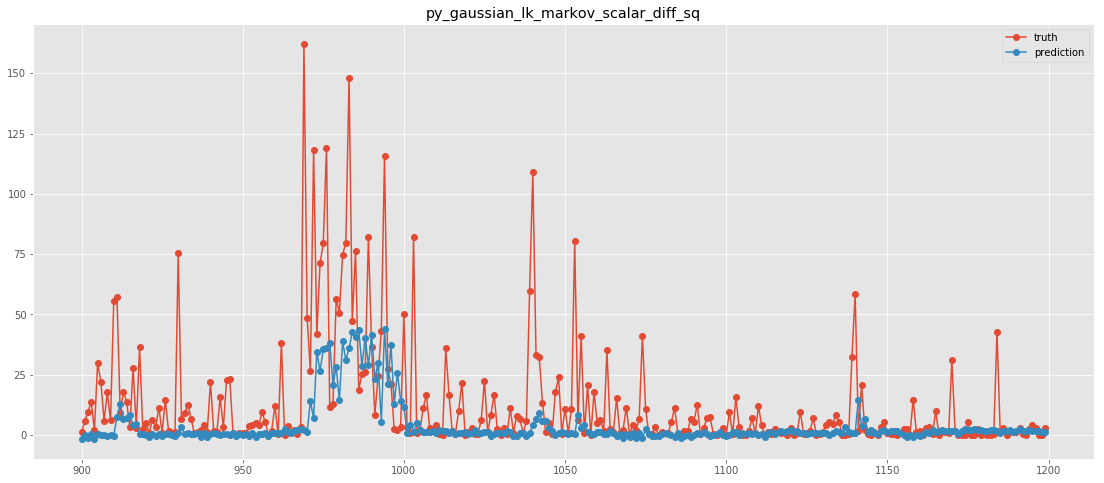

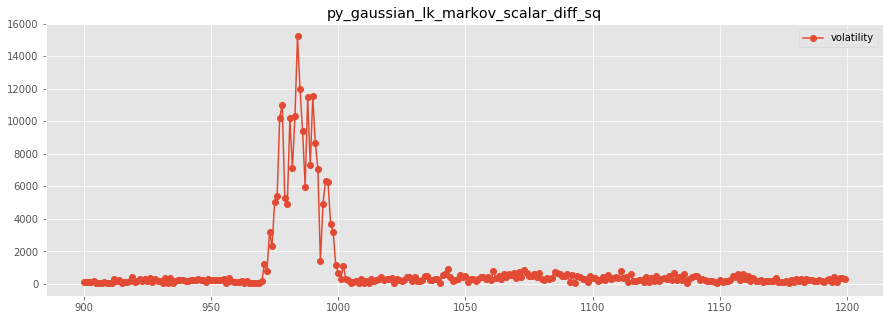

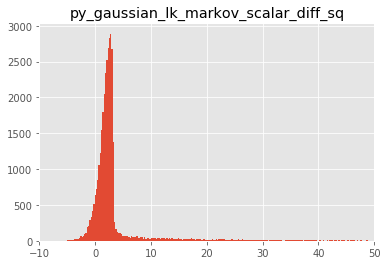

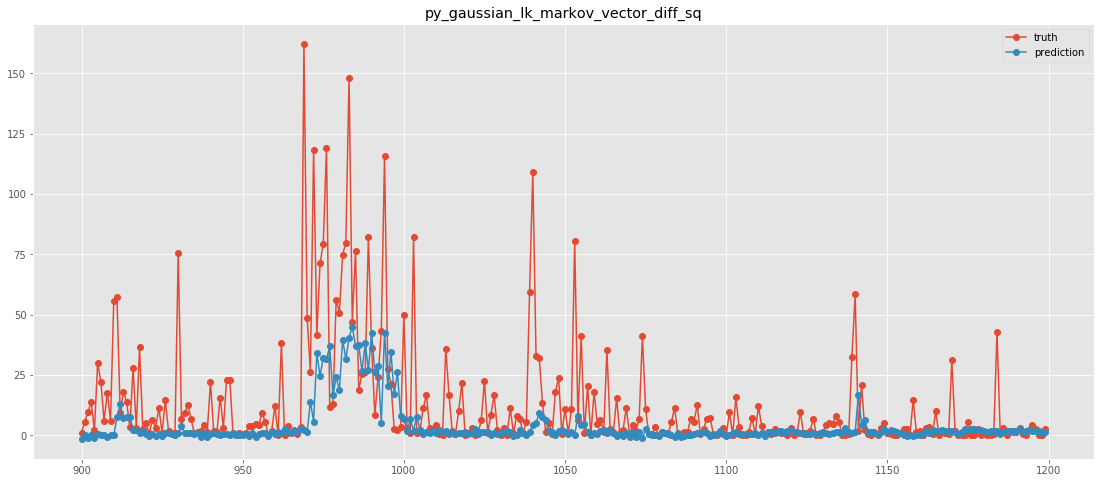

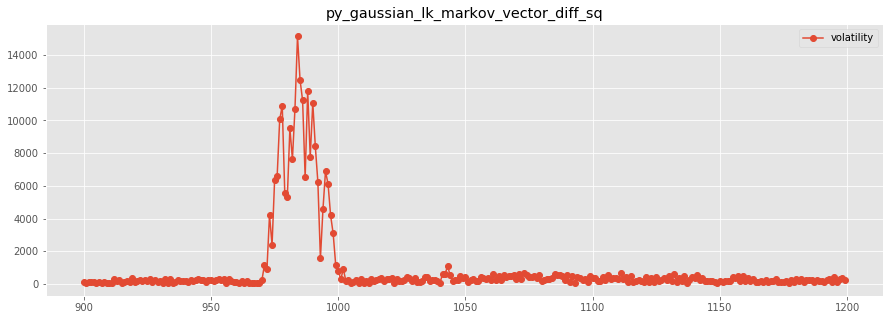

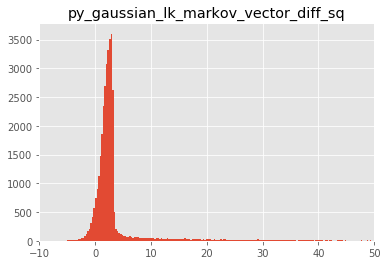

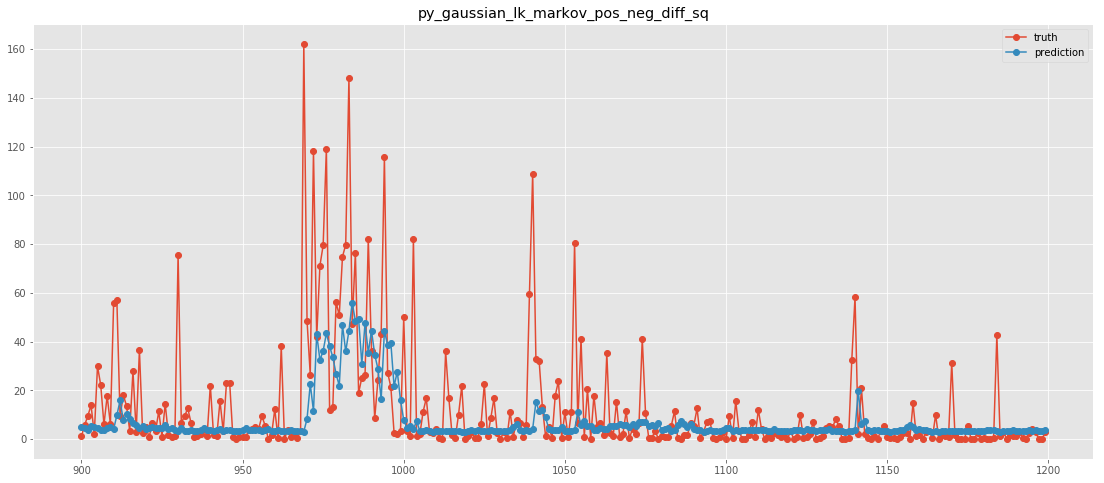

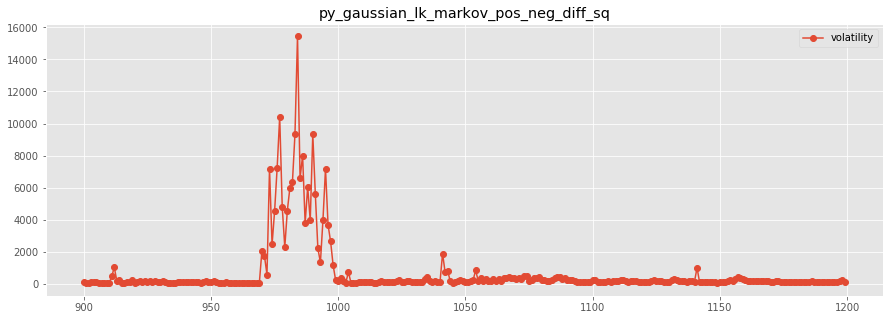

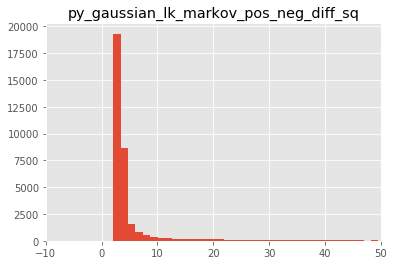

In [12]:

for tmp_path in gaussian_lk:
    
    print("\n -------- ", tmp_path)
    
    result_plot(ts_y, 
                path_res + tmp_path, 
                plot_l, 
                plot_r, 
                tmp_path)